In [1]:
# Import the relevant modules to be used
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import struct
import random
from timeit import default_timer as timer

# Handwritten digit recognition

This notebook is a study on the performance of Linear Regression and K-Nearest Neighbors methods in the task of classifying handwritten digits. This study is motivated by the exercise 2.8 of *Elements of Statistical learning* book. 

## The MNIST Database

The dataset we're going to use for this exercise is the [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/). Here are a few things to know about the data:

- It has a training set of 60,000 examples, and a test set of 10,000 examples. 

- The images and the labels are in separate files, both of them following a format known as IDX, which looks like this:

```
magic number 
size in dimension 0 
size in dimension 1 
size in dimension 2 
..... 
size in dimension N 
data
```

- The magic number is a 4-bytes integer: the first two bytes are always 0; the 3rd byte codes the type of data, in this case, it will always be 0x08 (which holds for unsigned byte); the 4th byte represents the dimension of the data, which is 3 for the images file (number of images x height x width) and 1 for the labels file (number of labels).

## Loading the dataset

This is a possible implementation for loading the MNIST dataset:

In [2]:
def validate(field, expected, actual):
    """Helper function to validate file metadata."""
    if expected != actual:
        raise Exception('Invalid ' + field + '. Expected ' + str(expected) + ' but got ' + str(actual))

def read_next_int(reader):
    """Reads the next 4 bytes of a buffer and casts to integer. It assumes big-endian order."""
    return struct.unpack('>I', reader.read(4))[0]

def load_images(path, samples):
    """Load a dataset of images into a matrix with <samples> rows, where each row <i> contains 28*28 elements
    representing the pixels of the <ith> image of that dataset. Each pixel is a unsigned int, which means it
    can take values from 0 (white) up to 255 (black).
    """
    with gzip.open(path) as gz:
        validate('magic number', 0x0803, read_next_int(gz))            
        validate('number of samples', samples, read_next_int(gz))
        validate('image resolution', [28, 28], [read_next_int(gz), read_next_int(gz)])            
        images = np.frombuffer(gz.read(samples * 28 * 28), dtype = np.uint8)
    return images.reshape((samples, 28 * 28))                
        
def load_labels(path, samples):    
    """Load the dataset of labels into a matrix with <samples> rows, where each row <i> contains 1 element
    representing the label of the <ith> image of the corresponding image dataset. Each label can be either
    0, 1, 2, 3, 4, 5, 6, 7, 8 or 9.
    """
    with gzip.open(path) as gz:
        validate('magic number', 0x801, read_next_int(gz))
        validate('number of samples', samples, read_next_int(gz))        
        labels = np.frombuffer(gz.read(samples), dtype = np.uint8)
    return labels.reshape((samples, 1))

def load_dataset(images_data_path, labels_data_path, samples):
    """Loads both images and labels files into a single matrix with <samples> rows, where each row contains
    28*28 + 1 elements, where the first 28*28 elements are the pixels of the image and the last element is 
    the label for that image.
    """
    images = load_images(images_data_path, samples)
    labels = load_labels(labels_data_path, samples)
    return np.hstack((images, labels))

In [3]:
# Loading the training and test dataset

training_dataset = load_dataset("data/training_images_idx3_ubyte.gz", "data/training_labels_idx1_ubyte.gz", 60000)
print("Loaded training data!")

# Prints the first image of the training set. Looking at the output, we know from the last element that this is a 5
print(training_dataset[0]) 

test_dataset  = load_dataset("data/test_images_idx3_ubyte.gz", "data/test_labels_idx1_ubyte.gz", 10000)
print("\n\n Loaded test data")

# ...And this is a 7
print(test_dataset[0]) 

Loaded training data!
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 

## Visualizing the image dataset

Now that we know how to load the dataset to our program, it would be cool to visualize some of the images to see how it looks like. A function that renders a random image from the dataset could be implemented like below: 

In [158]:
def render_random_image(dataset):    
    """Renders a random image from the given dataset"""
    random_sample = random.randint(0, len(dataset))     
    plt.imshow(dataset[random_sample,:-1].reshape(28,28), cmap="gray_r") # removes the label (last element) and reshapes to 28x28 pixels
    plt.axis('off')
    print("Sample number: #", random_sample)
    print("Image Label: ", dataset[random_sample,-1])
    print("Image classification: ", classify_image(dataset[random_sample,:-1]))

Sample number: # 55983
Image Label:  4
Image classification:  4


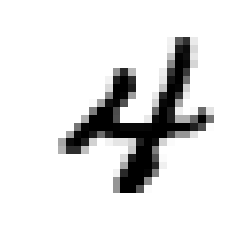

In [194]:
render_random_image(training_dataset) # samples 1 of the 60k images from the training dataset

## Linear regression

Let `N` be the number of samples in the training set, `p` be the input space dimension (in this case, 28*28 = 784) and `X` the N x p input matrix. Our linear regression function is given by:

$$\hat{Y} = X^T \hat\beta,$$

where 
$$\hat\beta = (X^T X)^{-1}X^TY$$

In [39]:
def dataset_for_digit(n):
    dataset = np.copy(training_dataset)
    for sample in dataset:
        if sample[784] == n:
            sample[784] = 1
        else:
            sample[784] = 0               
    return dataset    

In [85]:
def compute_beta(X, Y):
    # Q, R = np.linalg.qr(X)
    # return np.linalg.inv(R).dot(Q.T).dot(Y)    
    return np.linalg.lstsq(X,Y, rcond=None)[0]
    
def linear_regression(X, beta):
    [y] = X.T.dot(beta)  
    return y

In [145]:
def compute_betas():
    betas = []
    for i in range(9):
        digit_dataset = dataset_for_digit(i)
        digit_beta = compute_beta(digit_dataset[:, :-1], digit_dataset[:, -1:])
        betas.append(digit_beta)
    return betas

In [146]:
start = timer()
betas = compute_betas()
end = timer()

print("Time to compute betas: {:.2f} seconds".format(end - start))

Time to compute betas: 17.77 seconds


In [153]:
def classify_image(image):
    scores = []
    for beta in betas:
        scores.append(linear_regression(image, beta))
    return scores.index(max(scores))